# Combining the processed crop data

In [1]:
import os, json
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import numpy as np
import pandas as pd
import geopandas as gpd
import seaborn as sns
from tools import get_product_name_dict
import matplotlib.pyplot as plt
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)
pd.options.mode.chained_assignment = None
pd.set_option('display.max_rows', 100)

In [2]:
# Country to be combined ==================================== #
# [Afghanistan and Yemen] will be excluded for the HarvestStat paper data
country_code_list = [
    'AF','AO','BF','BI','BJ','CD','CF','CM','ET','GN','KE','LR','LS','MG','ML','MR','MW','MZ',
    'NE','NG','RW','SD','SL','SN','SO','SS','TD','TG','TZ','UG','ZA','ZM','ZW','YE',
]
# =========================================================== #

## Combine the processed crop data and shapefile

In [3]:
# Product mapping and selection ============================= #
container = []
for country_code in country_code_list:
    df = pd.read_csv('../data/crop/adm_crop_production_%s.csv' % country_code, index_col=0)
    container.append(df)
df = pd.concat(container, axis=0).reset_index(drop=True)
# Change country name
df['country'] = df['country'].replace({'Congo, The Democratic Republic of the': 'DRC'})
# Check all product names are in the dictionary
product_name_dict = get_product_name_dict()     # Predefined product name mapping
product_diff = set(df['product'].unique()) - set(product_name_dict.values())
if len(product_diff) > 0:
    for p in product_diff:
        country = df[df['product'] == p]['country'].unique()
        print(p, country)
# Select products to remove with rules:
# 1. The product is only produced in a single country.
# 2. The product has less than 200 data points.
cp_count = df[df['indicator'] == 'production'].pivot_table(index='country_code',columns='product', values='value', aggfunc='count').fillna(0).astype(int)
product_single_country = cp_count.columns[(np.sum(cp_count > 0) == 1)]
product_low_data_points = cp_count.columns[cp_count.sum(0) < 200]
product_remove = list(set(product_single_country) & set(product_low_data_points))
cp_remove = cp_count.loc[:, cp_count.columns.isin(product_remove)]
cp_remove = cp_remove[cp_remove.sum(1) > 0]
product_remove_dict = {index: cp_remove.columns[row > 0].tolist() for index, row in cp_remove.iterrows()}
# Manually define products to remove or keep ---------------- #
product_keep = []
product_remove_country = {
    'ET':['Beans (mixed)'],
    'BJ':['Green Pea'],
}
product_keep_country = {
    'ZA': ['Maize (Yellow)']
}
combined_remove_dict = {}
for country, products in product_remove_dict.items():
    if country in product_remove_country:
        products += product_remove_country[country]
    if country in product_keep_country:
        products = list(set(products) - set(product_keep_country[country]))
    combined_remove_dict[country] = products
# ----------------------------------------------------------- #
num_country = len(combined_remove_dict.keys())
num_product = len(set([p for ps in combined_remove_dict.values() for p in ps]))
print('Total %02d products are selected to remove over %02d countries.' % (num_product, num_country))
for country, products in combined_remove_dict.items():
    print('%s: %s' % (country, ', '.join(products)))
# =========================================================== #

Cooking Banana ['Burundi' 'DRC' 'Cameroon' 'Rwanda' 'Uganda']
Total 62 products are selected to remove over 12 countries.
BI: Cassava (non-bitter), Rice (not husked)
BJ: Colocynth, Green Pea
ET: Beans (Red), Enset, Gibto, Grass Pea, Kabuli Chick Pea, Safflower Seed, Swiss Chard, Vetch, Beans (mixed)
MG: African oil palm nut, Artichoke, Broccoli, Clove, Cocoa, Fibers, Fodder crop, Other stem vegetables, Pulses (dry), Strawberry, Vanilla
MW: Beans (Pinto)
MZ: Beans (Lima), Beans (Rosecoco), Cashew (unshelled), Groundnuts (In Shell, Large), Groundnuts (In Shell, Small), Macadamia, Other root/tuber vegetable, Spanish Peanut, Sweet Potatoes (Non-Orange), Sweet Potatoes (Orange), Virginia Peanut
NE: Anise, Basil, Coriander, Gourd, Henna, Tigernut
NG: Groundnuts (Without Shell)
RW: Cauliflowers, Champignon, Leeks, Spinach
SD: Cotton (Egyptian)
YE: Almond, Apple, Apricot, Beans (Green), Beans (Red Kidney), Cantaloupe, Date, Fig, Mandarin Orange, Peach, Pomegranate, Quince, Vegetables
ZA: Canol

In [4]:
# Merge crop data =========================================== #
container = []
for country_code in country_code_list:
    df = pd.read_csv('../data/crop/adm_crop_production_%s.csv' % country_code, index_col=0)
    # A bug may set entries without QC flags, which should be 0, to NaN. Find these and replace them with a QC flag of 0
    df.loc[np.isnan(df.QC_flag),'QC_flag'] = 0
    # Remove the selected products per country
    if country_code in combined_remove_dict.keys():
        df = df.loc[~(np.isin(df['product'],combined_remove_dict[country_code]))]
    # Pivot table
    cols_raw = df.columns
    cols = [
        'fnid', 'country', 'country_code', 'admin_1', 'admin_2', 'name',   
        'season_name', 'planting_year', 'planting_month',
        'harvest_year', 'harvest_month', 'crop_production_system', 'QC_flag'
    ]
    area = df[df['indicator'] == 'area'].pivot_table(index = cols, columns = 'product', values='value', aggfunc='sum')
    prod = df[df['indicator'] == 'production'].pivot_table(index = cols, columns = 'product', values='value', aggfunc='sum')
    crop = prod/area
    area = area.stack().rename('value').reset_index()
    area['indicator'] = 'area'
    prod = prod.stack().rename('value').reset_index()
    prod['indicator'] = 'production'
    crop = crop.stack().rename('value').reset_index()
    crop['indicator'] = 'yield'
    df = pd.concat([area, prod, crop])[cols_raw]
    # Reset QC flags (which were aggregated) to be 0/1
    df.loc[(df.QC_flag!=0)]['QC_flag']=1
    container.append(df)
df = pd.concat(container, axis=0).reset_index(drop=True)
# Change country name
df['country'] = df['country'].replace({'Congo, The Democratic Republic of the': 'DRC'})
# Pivot table
ind = ['fnid','country','country_code','admin_1','admin_2','product','season_name','planting_year','planting_month','harvest_year','harvest_month','crop_production_system','QC_flag']
pivot = df.pivot_table(index = ind, columns = 'indicator', values='value', aggfunc='count')
assert pivot.max().max() == 1 # checking duplicates
pivot = df.pivot_table(index = ind, columns = 'indicator', values='value').reset_index()
pivot = pivot.sort_values(ind)
pivot.columns.name = None
# =========================================================== #

In [5]:
# Merge the shapefiles ====================================== #
path_dir = '../data/shapefile/fewsnet/'
shape_fn_list = []
# - Asia
shape_fn_list.append(os.path.join(path_dir, 'AF_Admin1_2017.shp')) # Afghanistan Admin1 in 2017
shape_fn_list.append(os.path.join(path_dir, 'YE_Admin1_2014.shp')) # Yemen Admin1 in 2014
# - East Africa
shape_fn_list.append(os.path.join(path_dir, 'BI_Admin1_1998.shp')) # Brundi Admin1 in 1998
shape_fn_list.append(os.path.join(path_dir, 'ET_Admin2_2019.shp')) # Ethiopia Admin2 in 2019
shape_fn_list.append(os.path.join(path_dir, 'KE_Admin1_2009.shp')) # Kenya Admin1 in 2009
shape_fn_list.append(os.path.join(path_dir, 'KE_Admin1_2013.shp')) # Kenya Admin1 in 2013
shape_fn_list.append(os.path.join(path_dir, 'SO_Admin1_1990.shp')) # Somalia Admin1 in 1990
shape_fn_list.append(os.path.join(path_dir, 'SO_Admin2_1990.shp')) # Somalia Admin2 in 1990
shape_fn_list.append(os.path.join(path_dir, 'MG_Admin2_2009.shp')) # Madagascar Admin2 in 2009
shape_fn_list.append(os.path.join(path_dir, 'MW_Admin2_2018.shp')) # Malawi Admin2 in 2018
shape_fn_list.append(os.path.join(path_dir, 'MZ_Admin1_2021.shp')) # Mozambique Admin1 in 2013
shape_fn_list.append(os.path.join(path_dir, 'RW_Admin2_2006.shp')) # Rwanda Admin2 in 2006
shape_fn_list.append(os.path.join(path_dir, 'SS_Admin1_2011.shp')) # South Sudan Admin1 in 2011
shape_fn_list.append(os.path.join(path_dir, 'TZ_Admin1_2012.shp')) # Tanzania Admin1 in 2012
shape_fn_list.append(os.path.join(path_dir, 'UG_Admin2_2007.shp')) # Uganda Admin2 in 2007
shape_fn_list.append(os.path.join(path_dir, 'ZM_Admin2_2011.shp')) # Zambia Admin2 in 2011
shape_fn_list.append(os.path.join(path_dir, 'ZW_Admin1_2011.shp')) # Zimbabwe Admin1 in 2011
shape_fn_list.append(os.path.join(path_dir, 'ZW_Admin2_2011.shp')) # Zimbabwe Admin2 in 2011
# - Central Africa
shape_fn_list.append(os.path.join(path_dir, 'AO_Admin1_2008.shp')) # Angola Admin1 in 2008
shape_fn_list.append(os.path.join(path_dir, 'CM_Admin1_2008.shp')) # Cameroon Admin1 in 2008
shape_fn_list.append(os.path.join(path_dir, 'CF_Admin1_2003.shp')) # Central African Republic Admin1 in 2003
shape_fn_list.append(os.path.join(path_dir, 'TD_Admin1_2012.shp')) # Chad Admin1 in 2012
shape_fn_list.append(os.path.join(path_dir, 'CD_Admin1_2015.shp')) # DRC Admin1 in 2015
# - North Africa
shape_fn_list.append(os.path.join(path_dir, 'MR_Admin1_1990.shp')) # Mauritania Admin1 in 1990
shape_fn_list.append(os.path.join(path_dir, 'SD_Admin1_2013.shp')) # Sudan Admin1 in 2013
# - West Africa
shape_fn_list.append(os.path.join(path_dir, 'BJ_Admin2_2015.shp')) # Benin Admin2 in 2015
shape_fn_list.append(os.path.join(path_dir, 'BF_Admin2_2020.shp')) # Burkina Faso Admin2 in 2020
shape_fn_list.append(os.path.join(path_dir, 'CM_Admin2_2008.shp')) # Cameroon Admin2 in 2008
shape_fn_list.append(os.path.join(path_dir, 'GN_Admin2_1990.shp')) # Guinea Admin2 in 1990
shape_fn_list.append(os.path.join(path_dir, 'LR_Admin1_2008.shp')) # Liberia Admin1 in 2008
shape_fn_list.append(os.path.join(path_dir, 'ML_Admin1_2016.shp')) # Mali Admin1 in 2016
shape_fn_list.append(os.path.join(path_dir, 'NE_Admin2_2012.shp')) # Niger Admin2 in 2012
shape_fn_list.append(os.path.join(path_dir, 'NG_Admin1_1996.shp')) # Nigeria Admin1 in 1996
shape_fn_list.append(os.path.join(path_dir, 'SN_Admin2_2008.shp')) # Senegal Admin2 in 2008
shape_fn_list.append(os.path.join(path_dir, 'SL_Admin2_1960.shp')) # Sierra Leone Admin2 in 1960
shape_fn_list.append(os.path.join(path_dir, 'TG_Admin2_2009.shp')) # Togo Admin2 in 2009
# - Southern Africa
shape_fn_list.append(os.path.join(path_dir, 'LS_Admin1_1980.shp')) # Lesotho Admin1 in 1980
shape_fn_list.append(os.path.join(path_dir, 'ZA_Admin1_1994.shp')) # South Africa Admin1 in 1994
# Merge the shapefiles
shape = pd.concat([gpd.read_file(fn).to_crs(epsg=4326) for fn in shape_fn_list], axis=0).reset_index(drop=True)
shape['COUNTRY_ISO'] = shape['FNID'].apply(lambda x: x[:2])
shape = shape[['FNID','COUNTRY_ISO','ADMIN0','ADMIN1','ADMIN2','geometry']]
shape = shape.sort_values('FNID').reset_index(drop=True)
# Check all fnid in the crop data are in the shapefile
fnid_diff = set(pivot['fnid'].unique()) - set(shape['FNID'].unique())
assert len(fnid_diff) == 0
# Manual correction
# Drop a row if FNID is "ZW2011A21503" and ADMIN2 is "Hwange Urban"
shape = shape[~((shape['FNID'] == 'ZW2011A21503') & (shape['ADMIN2'] == 'Hwange Urban'))]
assert len(shape['FNID'].unique()) == shape.shape[0]
# Reduce to designated countries
if True: shape = shape[shape['COUNTRY_ISO'].isin(country_code_list)].reset_index(drop=True)
# Create country boundary (Admin0)
admin0 = shape.copy(deep=True)
admin0['ADMIN_CODE'] = admin0['FNID'].apply(lambda x: x[:8])
admin0 = admin0.to_crs(epsg=3857)
admin0['geometry'] = admin0['geometry'].buffer(200)
admin0 = admin0.dissolve(by='ADMIN_CODE')
admin0['geometry'] = admin0['geometry'].buffer(-200)
admin0 = admin0.loc[~admin0.index.isin(['KE2009A1','SO1990A1','ZW2011A1']),:]
admin0[['ADMIN1','ADMIN2']] = ''
admin0['FNID'] = admin0.index
admin0['FNID'] = admin0['FNID'].apply(lambda x: x[:-1]+'0')
admin0 = admin0.reset_index(drop=True)
admin0 = admin0.to_crs(epsg=4326)
# Merge
shape = pd.concat([admin0, shape], ignore_index=True).reset_index(drop=True)
shape = shape[['FNID','ADMIN0','ADMIN1','ADMIN2','geometry']]
shape = shape.sort_values(by=['FNID']).reset_index(drop=True)
# Change country_name
shape['ADMIN0'] = shape['ADMIN0'].replace({'Democratic Republic of the Congo': 'DRC'})
# =========================================================== #

In [6]:
# Save the data (All-purpose) =============================== #
fn_out = '../public/hvstat_data.csv'
pivot.to_csv(fn_out, index=False)
print('%s is saved (%.2f MB).' % (fn_out, os.path.getsize(fn_out)/1024**2))
# Simplify the shapefile
shape_simplified = shape.copy()
shape_simplified.geometry = shape_simplified.geometry.simplify(0.001)
fn_out = '../public/hvstat_boundary.gpkg'
shape_simplified.to_file(fn_out, driver='GPKG')
print('%s is saved (%.2f MB).' % (fn_out, os.path.getsize(fn_out)/1024**2))
# =========================================================== #

# Save the data (Paper version) ============================= #
# Exclude countries outside of Africa
pivot = pivot[~pivot['country_code'].isin(['AF','YE'])].reset_index(drop=True)
# Version number
version = '1.0'
fn_out = f'../public/hvstat_data_v{version}.csv'
pivot.to_csv(fn_out, index=False)
print('%s is saved (%.2f MB).' % (fn_out, os.path.getsize(fn_out)/1024**2))
fn_out = f'../public/hvstat_boundary_v{version}.gpkg'
# Select boundaries only shown in the data
admin_level = pivot['fnid'].apply(lambda x: x[:8]).unique()
shape_simplified = shape_simplified[shape_simplified['FNID'].apply(lambda x: x[:8]).isin(admin_level)].reset_index(drop=True)
shape_simplified.to_file(fn_out, driver='GPKG')
print('%s is saved (%.2f MB).' % (fn_out, os.path.getsize(fn_out)/1024**2))
# =========================================================== #

../public/hvstat_data.csv is saved (21.54 MB).
../public/hvstat_boundary.gpkg is saved (10.78 MB).
../public/hvstat_data_v1.0.csv is saved (20.80 MB).
../public/hvstat_boundary_v1.0.gpkg is saved (7.86 MB).


## Summary of "HarvestStat_v1.0_data.csv"

In [7]:
version = '1.0'
shape = gpd.read_file(f'../public/hvstat_boundary_v{version}.gpkg')
shape = shape[shape['FNID'].apply(lambda x: x[-2:] != 'A0')].reset_index(drop=True)
df = pd.read_csv(f'../public/hvstat_data_v{version}.csv')
df = df.merge(shape[['FNID','ADMIN0','ADMIN1','ADMIN2']], left_on='fnid', right_on='FNID')
df = df.rename(columns={'ADMIN1':'admin1','ADMIN2':'admin2','season_name':'season'})
df = df[['fnid','country','admin1','admin2','product','season','harvest_month','harvest_year','production']]
cps = df[['country','product','season']].drop_duplicates().reset_index(drop=True)
df['admin'] = df['fnid'].apply(lambda x: x[2:8])
table = pd.DataFrame(
    index=pd.MultiIndex.from_frame(df[['country','admin','season']].drop_duplicates()),
    columns= cps['product'].unique(),
    data = '-'
).rename_axis(columns='product')
for i, (country_name, product_name, season_name) in cps.iterrows():
    fnids_country = shape.loc[shape['ADMIN0'] == country_name, 'FNID']
    sub = df[
        (df['country'] == country_name) &
        (df['product'] == product_name) &
        (df['season'] == season_name)
    ]
    if sub.shape[0] > 0:
        count = sub.pivot_table(index='harvest_year', columns='fnid', values='production', aggfunc='count', fill_value=0)
        mean_count = count.sum().mean()
        string = '%d (%d/%d)' %  (mean_count, count.shape[1], len(fnids_country))
    else:
        string = '-'
    table.loc[pd.IndexSlice[country_name,:,season_name],product_name] = string
print('Mean record years (recorded districts / total districts)')
print(table.shape)
table

Mean record years (recorded districts / total districts)
(72, 92)


product                                                   Banana  \
country                      admin  season                         
Angola                       2008A1 Main              10 (18/18)   
Burkina Faso                 2020A2 Main                       -   
                                    Annual                     -   
Burundi                      1998A1 Season A          17 (16/17)   
                                    Season B          14 (16/17)   
                                    Season C          14 (16/17)   
Benin                        2015A2 Main                       -   
                                    Annual                     -   
DRC                          2015A1 Main                       -   
Central African Republic     2003A1 Main                       -   
Cameroon                     2008A2 Annual             2 (41/58)   
                                    North 1st Season           -   
                                    North 2nd Season           -   
                                    1st Season                 -   
                                    2nd Season                 -   
Ethiopia                     2019A2 Meher              7 (56/84)   
Guinea                       1990A2 Main                       -   
Kenya                        2013A1 Annual             2 (46/47)   
                                    Long                       -   
                                    Short                      -   
Liberia                      2008A1 Main                       -   
Lesotho                      1980A1 Summer                     -   
                                    Winter                     -   
Madagascar                   2009A2 Annual             1 (22/22)   
Mali                         2016A1 Main                       -   
Mauritania                   1990A1 Annual                     -   
                                    Bas-fond                   -   
                                    Dam retention              -   
                                    Main                       -   
                                    Walo                       -   
                                    Decrue controlee           -   
                                    Hot off-season             -   
                                    Cold off-season            -   
Malawi                       2018A2 Main               3 (24/32)   
                                    Annual                     -   
                                    Winter                     -   
Mozambique                   2021A1 Main                       -   
                                    Annual                     -   
                                    Cotton season              -   
                                    Rice season         1 (3/11)   
Niger                        2012A2 Dry                        -   
                                    Main                       -   
Nigeria                      1996A1 Wet                 2 (7/37)   
                                    Annual                     -   
Rwanda                       2006A2 Season A           4 (30/30)   
                                    Season B           4 (30/30)   
                                    Season C                   -   
Sudan                        2013A1 Main                       -   
                                    Winter                     -   
Sierra Leone                 1960A2 Main               0 (13/14)   
Senegal                      2008A2 Main                       -   
                                    Main-off                   -   
Somalia                      1990A2 Deyr                       -   
                                    Gu                         -   
                                    Deyr-off                   -   
                                    Gu-off                     -   
South Sudan                  2011A1 Main                

## Map of processed countries

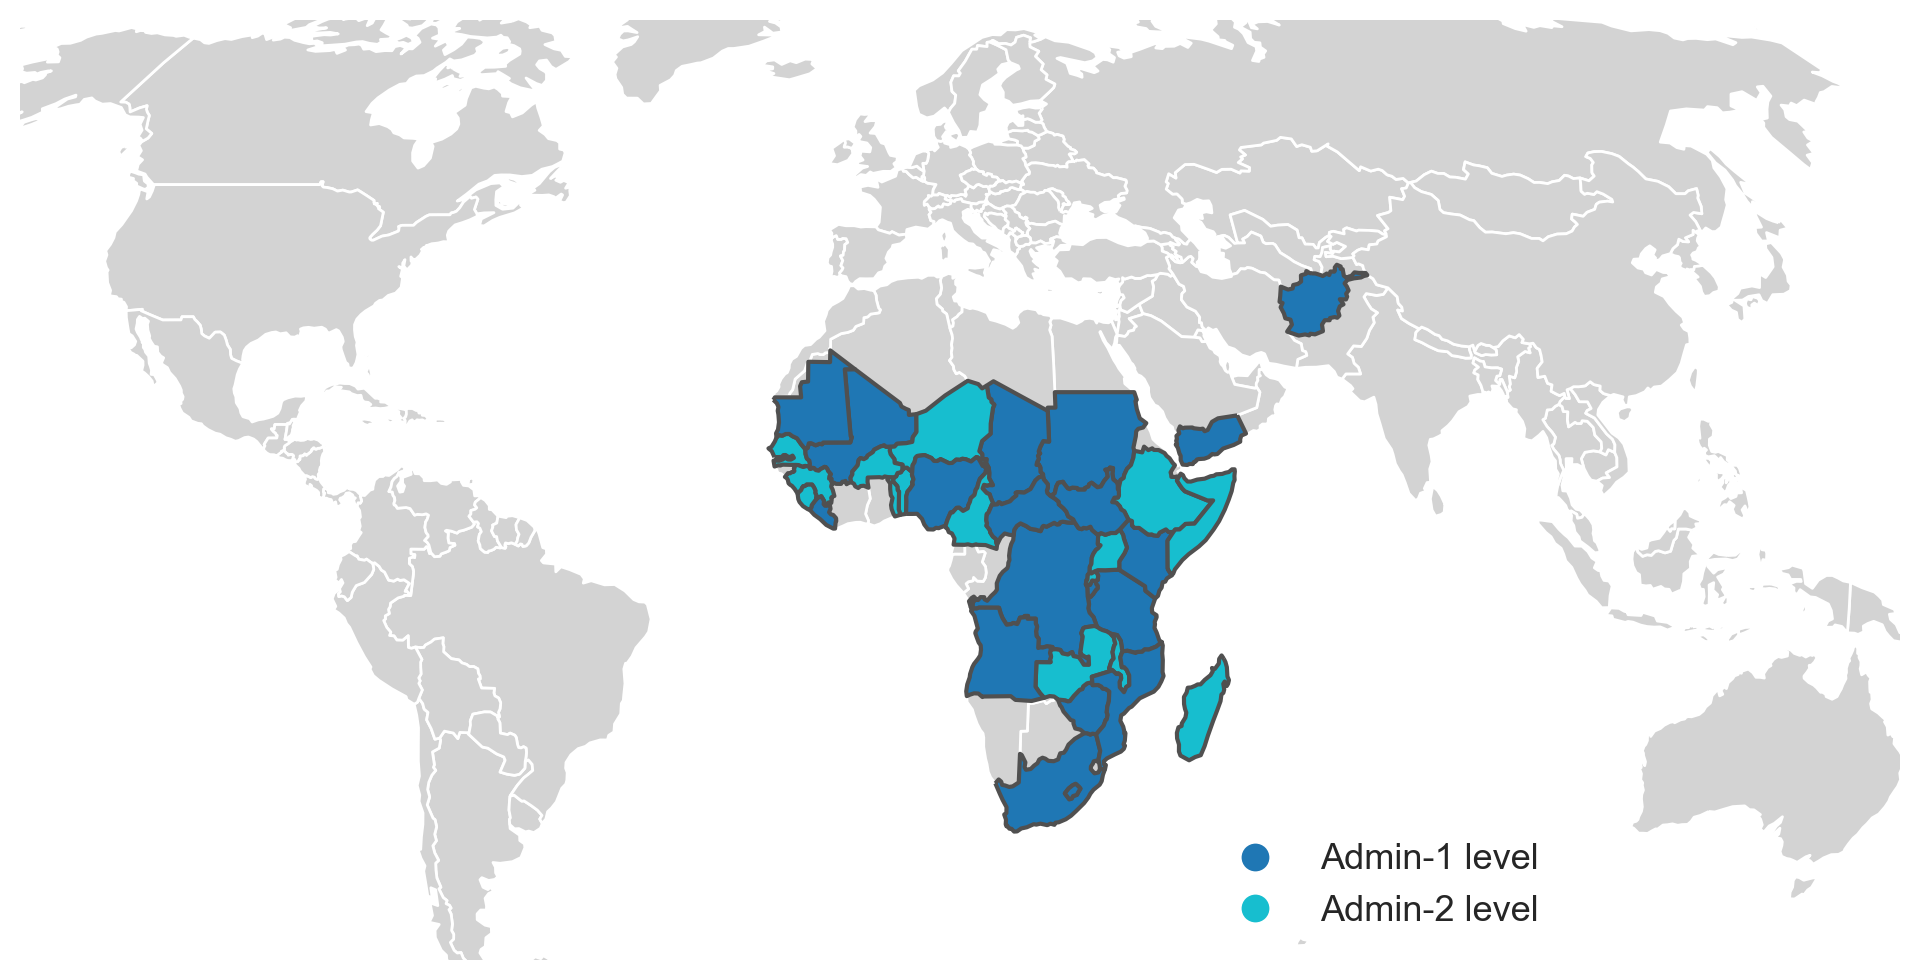

In [8]:
from matplotlib_inline.backend_inline import set_matplotlib_formats
set_matplotlib_formats('retina')
plt.rcParams['font.sans-serif'] = 'Arial'

# Little touch on world boundary ---------------------------- #
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
somalia = world[world['name'].isin(['Somalia', 'Somaliland'])].dissolve()
world = pd.concat([world[~world['name'].isin(['Somalia', 'Somaliland'])], somalia], axis=0)
world.replace(
    {   'Tanzania':'Tanzania, United Republic of',
        'Dem. Rep. Congo':'DRC',
        'Central African Rep.': 'Central African Republic',
        'S. Sudan':'South Sudan',
    }, inplace=True
)
df = pd.read_csv('../public/hvstat_data.csv')
# ----------------------------------------------------------- #
df['admin'] = df['fnid'].apply(lambda x: x[7])
country_processed = df[['country','admin']].drop_duplicates()
map_processed = world.merge(country_processed, left_on='name', right_on='country', how='inner')
assert len(map_processed['country'].dropna().unique()) == len(df['country'].unique())
map_processed['admin'] = map_processed['admin'].replace({'1':'Admin-1 level', '2':'Admin-2 level'})
# Plotting
mapdata = map_processed.copy().to_crs('esri:54030')
world = world.to_crs('esri:54030')
sns.set_style("white", {'axes.linewidth': 1, 'grid.color': 'black'})
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,5), facecolor='w')
ax.set_axis_off()
ax.set_aspect('equal')
ax.axis([-12000000, 14000000, -5500000, 7500000])
world.plot(ax=ax, color='lightgrey')
mapdata.plot(ax=ax, column='admin',linewidth=1.5, edgecolor='#505050', zorder=2,
            categorical=True, legend=True,
            legend_kwds={
                'loc': 'lower right', 
                'bbox_to_anchor':(0.825,0), 
                'frameon':False,
                'ncol':1,
                'fontsize':13
            },
)
plt.tight_layout()
plt.show()
fig.savefig('../docs/current_status_map.png', dpi=300, bbox_inches='tight')

In [9]:
country_processed.groupby('admin')['country'].count()
# Group by admin level, and aggregate texts of each country. When grouping, sort countries by alphabet order.
country_list = country_processed.sort_values('country')
country_list = country_list.groupby('admin')['country'].apply(lambda x: ', '.join(x)).reset_index()
for i, row in country_list.iterrows():
    print('Admin', row['admin'], ':', sum(country_processed['admin'] == row['admin']), 'countries')
    print(row['country'])
    print('')

Admin 1 : 19 countries
Afghanistan, Angola, Burundi, Central African Republic, Chad, DRC, Kenya, Lesotho, Liberia, Mali, Mauritania, Mozambique, Nigeria, South Africa, South Sudan, Sudan, Tanzania, United Republic of, Yemen, Zimbabwe

Admin 2 : 15 countries
Benin, Burkina Faso, Cameroon, Ethiopia, Guinea, Madagascar, Malawi, Niger, Rwanda, Senegal, Sierra Leone, Somalia, Togo, Uganda, Zambia

